# 用于调试deepspeech 提取固定参考帧

In [ ]:
import os
import numpy as np
import warnings
import resampy
from scipy.io import wavfile
from python_speech_features import mfcc
import tensorflow as tf



class DeepSpeech():
    def __init__(self,model_path):
        self.graph, self.logits_ph, self.input_node_ph, self.input_lengths_ph \
            = self._prepare_deepspeech_net(model_path)
        self.target_sample_rate = 16000

    def _prepare_deepspeech_net(self,deepspeech_pb_path):
        with tf.io.gfile.GFile(deepspeech_pb_path, "rb") as f:
            graph_def = tf.compat.v1.GraphDef()
            graph_def.ParseFromString(f.read())
        graph = tf.compat.v1.get_default_graph()
        tf.import_graph_def(graph_def, name="deepspeech")
        logits_ph = graph.get_tensor_by_name("deepspeech/logits:0") # delete deepspeech 
        input_node_ph = graph.get_tensor_by_name("deepspeech/input_node:0") # delete deepspeech 
        input_lengths_ph = graph.get_tensor_by_name("deepspeech/input_lengths:0") # delete deepspeech 

        return graph, logits_ph, input_node_ph, input_lengths_ph

    def conv_audio_to_deepspeech_input_vector(self,audio,
                                              sample_rate,
                                              num_cepstrum,
                                              num_context):
        # Get mfcc coefficients:
        features = mfcc(
            signal=audio,
            samplerate=sample_rate,
            numcep=num_cepstrum)
        
        # print("看这个MFCC feature 是否一样: ")
        # import pdb
        # pdb.set_trace() 

        # We only keep every second feature (BiRNN stride = 2):
        features = features[::2]

        # One stride per time step in the input:
        num_strides = len(features)

        # Add empty initial and final contexts:
        empty_context = np.zeros((num_context, num_cepstrum), dtype=features.dtype)
        features = np.concatenate((empty_context, features, empty_context))

        # Create a view into the array with overlapping strides of size
        # numcontext (past) + 1 (present) + numcontext (future):
        window_size = 2 * num_context + 1
        train_inputs = np.lib.stride_tricks.as_strided(
            features,
            shape=(num_strides, window_size, num_cepstrum),
            strides=(features.strides[0],
                     features.strides[0], features.strides[1]),
            writeable=False)

        # Flatten the second and third dimensions:
        train_inputs = np.reshape(train_inputs, [num_strides, -1])

        train_inputs = np.copy(train_inputs)
        train_inputs = (train_inputs - np.mean(train_inputs)) / \
                       np.std(train_inputs)

        return train_inputs

    def compute_audio_feature(self,audio_path):
        audio_sample_rate, audio = wavfile.read(audio_path)
        if audio.ndim != 1:
            warnings.warn(
                "Audio has multiple channels, the first channel is used")
            audio = audio[:, 0]
        if audio_sample_rate != self.target_sample_rate:
            resampled_audio = resampy.resample(
                x=audio.astype(np.float64),
                sr_orig=audio_sample_rate,
                sr_new=self.target_sample_rate)
        else:
            resampled_audio = audio.astype(np.float64)
        with tf.compat.v1.Session(graph=self.graph) as sess:



            input_vector = self.conv_audio_to_deepspeech_input_vector(
                audio=resampled_audio.astype(np.int16),
                sample_rate=self.target_sample_rate,
                num_cepstrum=26,
                num_context=9)

            # print("观察deepspeech的输出")
            # import pdb
            # pdb.set_trace() 
            
            network_output = sess.run(
                    self.logits_ph,
                    feed_dict={
                        self.input_node_ph: input_vector[np.newaxis, ...],
                        self.input_lengths_ph: [input_vector.shape[0]]})
            
            ds_features = network_output[::2,0,:]
        return ds_features


In [ ]:
# audio_path = '../asserts/training_data/split_video_25fps/bilibili_dataset_25fps_FFoutput3mukyw8o_part5.wav'
# model_path = '../asserts/output_graph.pb'
# DSModel = DeepSpeech(model_path)
# ds_feature = DSModel.compute_audio_feature(audio_path)
# print(ds_feature)

In [ ]:
# base_path = '../asserts/training_data/split_video_25fps'
# audio_name = 'bilibili_dataset_25fps_FFoutput3mukyw8o_part5'
# audio_path = f'{base_path}_audio/{audio_name}.wav'
# model_path = '../asserts/output_graph.pb'
# DSModel = DeepSpeech(model_path)
# ds_feature = DSModel.compute_audio_feature(audio_path)

# # CTC Decoder
# decoded, _ = tf.nn.ctc_greedy_decoder(
#     inputs=tf.transpose(ds_feature[np.newaxis, :, :], perm=[1, 0, 2]),
#     sequence_length=[ds_feature.shape[0]])

# # 用于将数字映射回字符的字典
# index2char = {0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e',
#                 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k',
#                 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q',
#                 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w',
#                 24: 'x', 25: 'y', 26: 'z', 27: "'", 28: ''} # CTC blank symbol for 28

# with tf.compat.v1.Session() as sess:
#     # 运行解码
#     decoded_texts = sess.run(tf.sparse.to_dense(decoded[0]))
    
#     # 将数字转换回字符
#     decoded_text = ''.join([index2char[d] for d in decoded_texts[0]])
#     print("Decoded text:", decoded_text)
    
#     # 解析帧对应的字符序列
#     frame_folders = np.array_split(range(ds_feature.shape[0]), np.ceil(ds_feature.shape[0] / 9.0))
#     char_per_frame = len(decoded_text) / len(frame_folders)  # 平均每个文件夹对应的字符数
#     for i, folder in enumerate(frame_folders):
#         folder_path = f'{base_path}_crop_face/{audio_name}/{i:06d}'
#         char_start_idx = int(i * char_per_frame)
#         char_end_idx = int((i + 1) * char_per_frame)
#         folder_text = decoded_text[char_start_idx:char_end_idx]  # 为这一组帧分配的文本

#         for frame in folder:
#             image_path = os.path.join(folder_path, f'{frame:06d}.jpg')
#             try:
#                 img = plt.imread(image_path)
#                 plt.imshow(img)
#                 plt.title(f'Frame {frame}')
                
#                 # 在图像上添加文字
#                 plt.text(10, 20, folder_text, color='red', fontsize=12, weight='bold')

#                 plt.axis('off')  # 不显示坐标轴
#                 plt.show()
                
#                 # 如果需要保存带有文字的图像
#                 # plt.savefig(f'{folder_path}/Frame_{frame}_with_text.jpg')
                
#             except FileNotFoundError:
#                 print(f'File not found: {image_path}')

## 直接从deepspeech txt 映射回去

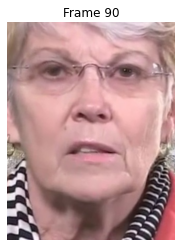

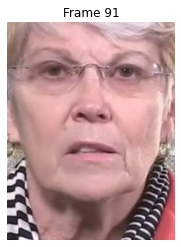

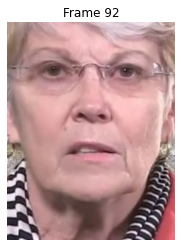

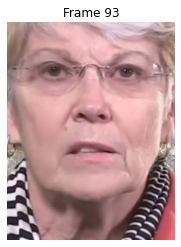

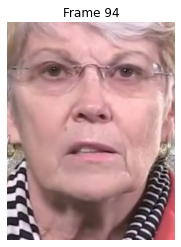

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, clear_output

# 读取TXT文件中的DeepSpeech特征
def read_deepspeech_features(txt_path):
    with open(txt_path, 'r') as f:
        lines = f.readlines()
    features = np.array([np.fromstring(line, sep=' ') for line in lines])
    return features

# 用于将数字映射回字符的字典
index2char = {0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e',
              6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k',
              12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q',
              18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w',
              24: 'x', 25: 'y', 26: 'z', 27: "'", 28: ''} # CTC blank symbol for 28

# 解码并绘制字符到视频帧
def decode_and_draw(txt_path, video_frames_dir):
    features = read_deepspeech_features(txt_path)
    
    for i, frame_logits in enumerate(features):
        char_index = np.argmax(frame_logits)
        decoded_char = index2char[char_index]

        # 计算图像所在的文件夹
        folder_index = i // 9
        folder_name = f'{folder_index:06d}'
        # 计算图像文件名
        image_file_name = f'{i:06d}.jpg'
        # 构建完整的图像路径
        image_path = os.path.join(video_frames_dir, folder_name, image_file_name)
        
        if os.path.exists(image_path):
            img = plt.imread(image_path)
            plt.imshow(img)
            plt.text(10, 20, decoded_char, color='red', fontsize=12, weight='bold')
            plt.axis('off')
            plt.title(f'Frame {i}')
            plt.show()
            input("Press Enter to continue...")  # 等待用户输入
            plt.close()
            
            # 检查用户是否输入了退出指令
            if user_input.lower() == 'quit':
                print("Exiting...")
                break

            # 每隔10张图，清除所有输出
            if (i + 1) % 10 == 0:
                clear_output(wait=True)

        else:
            print(f'File not found: {image_path}')


# 示例使用
txt_path = '../asserts/training_data/split_video_25fps_deepspeech/RD_Radio1_000_corrected_deepspeech.txt'
video_frames_dir = '../asserts/training_data/split_video_25fps_crop_face/RD_Radio1_000_corrected'
decode_and_draw(txt_path, video_frames_dir)

